<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Native Bayes Model

it's an important ML model used in classification. It's called 'naive' because we make some assumption to simplify the calculation.

It is based on the premise that the more information we gather about an event, the better estimate of the probability we can make. Bayes' theorem answers "what is the prob of Y given X occured?" - *conditional probability*.

* **prior** - the initial probability
* **event** - something that occurs which gives us information
* **posterior** - the final (and more accurate) probability calculated using prior probability and event.

Example:
* Prior: probability that the patient is sick (1/10,000)
* Event: the patient tested positive
* Posterior: probability that the patient is sick given that he is tested positive (99/(99+9999)=0.98%)

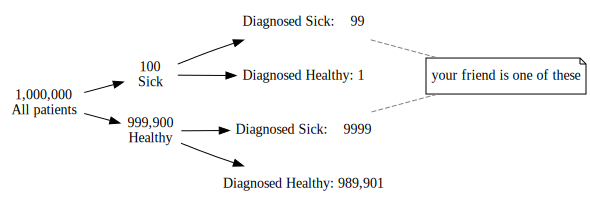

In [20]:
import graphviz

# Create a new Digraph
dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add nodes (parent and children)
dot.node('A', '1,000,000\nAll patients', shape='plaintext')
dot.node('S', '100\nSick', shape='plaintext')
dot.node('H', '999,900\nHealthy', shape='plaintext')
dot.node('SDS', 'Diagnosed Sick:    99', shape='plaintext')
dot.node('SDH', 'Diagnosed Healthy: 1', shape='plaintext')
dot.node('HDS', 'Diagnosed Sick:    9999', shape='plaintext')
dot.node('HDH', 'Diagnosed Healthy: 989,901', shape='plaintext')

# Add edges (connections)
dot.edge('A', 'S')
dot.edge('A', 'H')
dot.edge('S', 'SDS')
dot.edge('S', 'SDH')
dot.edge('H', 'HDS')
dot.edge('H', 'HDH')

dot.node('F', 'your friend is one of these', shape='note')
dot.edge('SDS', 'F', style='dashed', color='grey', arrowhead='none')
dot.edge('HDS', 'F', style='dashed', color='grey', arrowhead='none')
# Display the diagram
dot

In [17]:
99/(99+9999)  # prob of friend is sick

0.00980392156862745